<a href="https://colab.research.google.com/github/v670/MLProjects/blob/main/Predictive_Text_Generator1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing the Libraries





In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import os
import time
import requests
import tensorflow as tf
import matplotlib.pyplot as plt



## Load the Dataset

In [ ]:
path_to_file = tf.keras.utils.get_file('sherlock.txt', 'https://www.gutenberg.org/files/108/108-0.txt')

729088/719617 [==============================] - 0s 0us/step


In [ ]:
# Read, then decode for py2 compat.
text = open(path_to_file, 'rb').read().decode(encoding='utf-8')
# length of text is the number of characters in it
print(f'Length of text: {len(text)} characters')

Length of text: 706874 characters


## Prepare Text

We shall perform bare minimum cleanup of the text.The aim is to enable our model to understand the usage of words and its context. Typical preprocessing stems like stemming are not required in this case

In [ ]:
text=text[1265:]

#### A Quick Snippet of the Book




In [ ]:
text[0:200]

'THE ADVENTURE OF THE EMPTY HOUSE\r\n\r\n      It was in the spring of the year 1894 that all London was\r\n      interested, and the fashionable world dismayed, by the murder of\r\n      the Honourable Ronald'

## Creating Functions For Various Tasks

In [ ]:
import numpy as np

#character to integer and integer to character mapping
def char2idx_idx2char(vocab):
    char2idx = {u:i for i,u in enumerate(vocab)}
    idx2char = np.array(vocab)

    return char2idx,idx2char

#take the chunk of data as the input and target as one position shifted from input
def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text,target_text


#converting our whole text into integers
def text_to_label(text,char2idx):
    data = np.array([char2idx[c] for c in text])
    return data

#### Unique Character Count|Vocab Size

In [ ]:
vocab = sorted(set(text))
print('{} unique characters'.format(len(vocab)))

95 unique characters


In [ ]:
char2idx,idx2char = char2idx_idx2char(vocab)

In [ ]:
char2idx['T']

48

In [ ]:
text_as_int = np.array([char2idx[c] for c in text])

#### Text to Integer Sample

In [ ]:
print("{}  ------chartoint-------   {}".format(text[0:10],text_as_int[0:10]))

THE ADVENT  ------chartoint-------   [48 36 33  2 29 32 50 33 42 48]


## Prepare The Dataset

In [ ]:
seq_length = 100
examples_per_epoch = len(text)//(seq_length+1)

char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)

for i in char_dataset.take(5):
    print(idx2char[i.numpy()])

T
H
E
 
A


#### Prepare Batch

In [ ]:
sequences = char_dataset.batch(seq_length+1,drop_remainder=True)

for item in sequences.take(5):
    print(repr(''.join(idx2char[item.numpy()])))
    print('-'*110)

'THE ADVENTURE OF THE EMPTY HOUSE\r\n\r\n      It was in the spring of the year 1894 that all London was\r\n'
--------------------------------------------------------------------------------------------------------------
'      interested, and the fashionable world dismayed, by the murder of\r\n      the Honourable Ronald A'
--------------------------------------------------------------------------------------------------------------
'dair under most unusual and inexplicable\r\n      circumstances. The public has already learned those p'
--------------------------------------------------------------------------------------------------------------
'articulars\r\n      of the crime which came out in the police investigation, but a\r\n      good deal was'
--------------------------------------------------------------------------------------------------------------
' suppressed upon that occasion, since the case for\r\n      the prosecution was so overwhelmingly stron'
--------------------

In [ ]:
dataset = sequences.map(split_input_target)

In [ ]:
for input_example,target_example in dataset.take(1):
  print("Input Sentence:" ,repr(''.join(idx2char[input_example.numpy()])))
  print("Target Sentence:" ,repr(''.join(idx2char[target_example.numpy()])))

Input Sentence: 'THE ADVENTURE OF THE EMPTY HOUSE\r\n\r\n      It was in the spring of the year 1894 that all London was\r'
Target Sentence: 'HE ADVENTURE OF THE EMPTY HOUSE\r\n\r\n      It was in the spring of the year 1894 that all London was\r\n'


#### Prepare Training Batch

In [ ]:
BATCH_SIZE = 64

BUFFER_SIZE = 10000

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE,drop_remainder=True)

In [ ]:
dataset

<BatchDataset shapes: ((64, 100), (64, 100)), types: (tf.int64, tf.int64)>

## Models 





In [ ]:

import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing

def build_GRU(vocab_size, embedding_dim, rnn_units, batch_size):
    model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim,
                              batch_input_shape=[batch_size,None]),
    tf.keras.layers.GRU(rnn_units,
                        return_sequences=True,
                        stateful=True,
                        recurrent_initializer='glorot_uniform'),
    tf.keras.layers.Dense(vocab_size)
    ])
  
    print(model.summary())
    return model

def build_LSTM(vocab_size, embedding_dim, rnn_units, batch_size):
    model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim,
                              batch_input_shape=[batch_size,None]),
    tf.keras.layers.LSTM(rnn_units,
                        return_sequences=True,
                        stateful=True,
                        recurrent_initializer='glorot_uniform'),
    tf.keras.layers.Dense(vocab_size)
    ])
  
    print(model.summary())
    return model


def build_BiLSTM(vocab_size, embedding_dim, rnn_units, batch_size):
    model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim,
                              batch_input_shape=[batch_size,None]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(rnn_units,
                        return_sequences=True,
                        stateful=True,
                        recurrent_initializer='glorot_uniform')),
    tf.keras.layers.Dense(vocab_size)
    ])
  
    print(model.summary())
    return model

In [ ]:
def loss(labels, logits):
    return tf.keras.losses.sparse_categorical_crossentropy(labels,logits,from_logits=True)

#### Using GRU 

In [ ]:
vocab_size = len(vocab)
embedding_dim = 256
rnn_units = 1024

model_gru = build_GRU(vocab_size=vocab_size,
                    embedding_dim=embedding_dim,
                    rnn_units=rnn_units,
                    batch_size=BATCH_SIZE)
model_gru.compile(optimizer='adam',loss=loss)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (64, None, 256)           24320     
_________________________________________________________________
gru (GRU)                    (64, None, 1024)          3938304   
_________________________________________________________________
dense (Dense)                (64, None, 95)            97375     
Total params: 4,059,999
Trainable params: 4,059,999
Non-trainable params: 0
_________________________________________________________________
None




*   Setup CallBacks







We setup a Single Callback to store the Checkpoints

In [ ]:
# Directory where the checkpoints will be saved
checkpoint_dir = '/content/drive/MyDrive/CheckPoints/GRU1'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True,monitor='loss',save_best_only=True)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.2,
                              patience=5, min_lr=0.001)
callbacks = [checkpoint_callback,reduce_lr]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive




We have done the preprocessing and prepare our training dataset so now lets train it.We train it for a few epochs and observe the loss to understand whether it is learning or not

In [ ]:
EPOCHS = 30
history_1 = model_gru.fit(dataset, epochs=EPOCHS, callbacks=callbacks)

Epoch 1/30
172/172 [==============================] - 30s 128ms/step - loss: 2.6588
Epoch 2/30
172/172 [==============================] - 24s 128ms/step - loss: 1.9592
Epoch 3/30
172/172 [==============================] - 24s 130ms/step - loss: 1.6918
Epoch 4/30
172/172 [==============================] - 24s 130ms/step - loss: 1.5425
Epoch 5/30
172/172 [==============================] - 24s 131ms/step - loss: 1.4544
Epoch 6/30
172/172 [==============================] - 24s 131ms/step - loss: 1.3955
Epoch 7/30
172/172 [==============================] - 24s 131ms/step - loss: 1.3488
Epoch 8/30
172/172 [==============================] - 24s 130ms/step - loss: 1.3098
Epoch 9/30
172/172 [==============================] - 24s 131ms/step - loss: 1.2746
Epoch 10/30
172/172 [==============================] - 24s 130ms/step - loss: 1.2426
Epoch 11/30
172/172 [==============================] - 24s 130ms/step - loss: 1.2093
Epoch 12/30
172/172 [==============================] - 24s 130ms/step - lo

In [ ]:
model_gru.save('/content/drive/MyDrive/MODELS/GRU')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/MODELS/GRU/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/MODELS/GRU/assets


In [ ]:
model = build_GRU(vocab_size,embedding_dim,rnn_units, batch_size=1)
model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

model.build(tf.TensorShape([1,None]))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (1, None, 256)            16640     
_________________________________________________________________
gru_1 (GRU)                  (1, None, 1024)           3938304   
_________________________________________________________________
dense_1 (Dense)              (1, None, 65)             66625     
Total params: 4,021,569
Trainable params: 4,021,569
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
def generate_text(model, start_string):

    num_generate = 1000

    #convert context string into string indices
    input_eval = [char2idx[s] for s in start_string]
    input_eval = tf.expand_dims(input_eval, 0)

    #string for generated characters
    text_generated = []

    temperature = 1.0

    model.reset_states()

    #Loop till the required number of characters are generated
    for i in range(num_generate):
        predictions = model(input_eval)
        predictions = tf.squeeze(predictions, 0)

        #temperature helps control the character returned by the model 
        predictions = predictions/temperature
        #sampling ove a categorical distribution
        predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()
        
        #predicted character acts as an input for the next step
        input_eval = tf.expand_dims([predicted_id], 0)

        text_generated.append(idx2char[predicted_id])
  
    return (start_string+ ''.join(text_generated))

In [ ]:
print(generate_text(model, start_string=u"ROMEO: "))

ROMEO: God forbid!
Is ter our foe.

SICINIUS:
Master and trembling apes in esterlay'st things
that hand me oft have heard in his small guerts:
For when I have set the dule access of her match
That he himself stuck not mine eye and head,
A partial hours I reap to the mudialiest;
hopping to think I am thy childing be but light and waxard-wrick
And cites upon our abroad suddenly: let me be pronice,--
Grace with him till out of boldman--

GLOUCESTER:
Away, away! me, too well, and cruell you in a Chris night:
And when the sins of your sidenies, impartial if the six
Of time to come to woo thee for my wife. You'll swear
as you might part with you; and I'll bear
you wrong, and get thee more eyes;
And whet's a word or two in one word for your mouths,
And call him her apprehen in my love,
And strip by country's curre that slew my husband for your love
Than never yielded, he reverses, I have to you,
Shall, and I repent your sister.

VALERIA:
In girth in love than thought;
And when I met thou both

#### Using LSTM

In [ ]:
vocab_size = len(vocab)
embedding_dim = 256
rnn_units = 1024

model_lstm = build_LSTM(vocab_size=vocab_size,
                    embedding_dim=embedding_dim,
                    rnn_units=rnn_units,
                    batch_size=BATCH_SIZE)
model_lstm.compile(optimizer='adam',loss=loss)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (64, None, 256)           16640     
_________________________________________________________________
lstm (LSTM)                  (64, None, 1024)          5246976   
_________________________________________________________________
dense_2 (Dense)              (64, None, 65)            66625     
Total params: 5,330,241
Trainable params: 5,330,241
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
# Directory where the checkpoints will be saved
checkpoint_dir = '/content/drive/MyDrive/CheckPoints/LSTM1'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True,monitor='loss',save_best_only=True)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.2,
                              patience=5, min_lr=0.001)
callbacks = [checkpoint_callback,reduce_lr]

In [ ]:
EPOCHS = 30
history_2 = model_lstm.fit(dataset, epochs=EPOCHS, callbacks=callbacks)

Epoch 1/30
172/172 [==============================] - 31s 159ms/step - loss: 2.5939
Epoch 2/30
172/172 [==============================] - 29s 160ms/step - loss: 1.8680
Epoch 3/30
172/172 [==============================] - 29s 160ms/step - loss: 1.6242
Epoch 4/30
172/172 [==============================] - 29s 160ms/step - loss: 1.4968
Epoch 5/30
172/172 [==============================] - 29s 160ms/step - loss: 1.4189
Epoch 6/30
172/172 [==============================] - 29s 161ms/step - loss: 1.3640
Epoch 7/30
172/172 [==============================] - 29s 161ms/step - loss: 1.3201
Epoch 8/30
172/172 [==============================] - 29s 161ms/step - loss: 1.2821
Epoch 9/30
172/172 [==============================] - 29s 160ms/step - loss: 1.2464
Epoch 10/30
172/172 [==============================] - 30s 162ms/step - loss: 1.2121
Epoch 11/30
172/172 [==============================] - 29s 161ms/step - loss: 1.1772
Epoch 12/30
172/172 [==============================] - 30s 162ms/step - lo

In [ ]:
model_lstm.save('/content/drive/MyDrive/MODELS/LSTM')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/MODELS/LSTM/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/MODELS/LSTM/assets


In [ ]:
model = build_LSTM(vocab_size,embedding_dim,rnn_units, batch_size=1)
model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

model.build(tf.TensorShape([1,None]))

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (1, None, 256)            16640     
_________________________________________________________________
lstm_1 (LSTM)                (1, None, 1024)           5246976   
_________________________________________________________________
dense_3 (Dense)              (1, None, 65)             66625     
Total params: 5,330,241
Trainable params: 5,330,241
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
print(generate_text(model, start_string=u"ROMEO: "))

ROMEO: mbreast:
Rome greater coupans, whose vengeance but
thesend thee in a town, our duty, and the arm
Commit to the famier.

BRUTUS:
Manine's slander,
I burst unspoils, I do not know of any other:
Here in the posterns step.

PAULINA:
Good my friends,' mistress! I have proclaim'd
With that account-dacle, think now where I live;
For thou, the fool will please my letter to this law.
Here are the king here, I, ere my hang confess
The accorn' tall he equal it. I meant, to charge thee gentle,--thoresolved, to those wounded much.
Now, therefore face be fire; still wear the harm
Of honourable friends!' 'tis though the city fl gurns.

KATHARINA:
Her hatred merch, my lord growing water, news,
Yet witnessesp for thee till he came from them
Touching the Crespecupon; what a
be they but infirmity,
Might have my own good and that word 'll afout mine eyes,
That being but leish to me: O, then, God, in he
'They be granted, but not to be prevented.

PETRUCHIO:
Sir, I can scronger strew'd, and make me s


#### Using BiLSTM




In [ ]:
vocab_size = len(vocab)
embedding_dim = 256
rnn_units = 1024

model_bilstm = build_BiLSTM(vocab_size=vocab_size,
                    embedding_dim=embedding_dim,
                    rnn_units=rnn_units,
                    batch_size=BATCH_SIZE)
model_bilstm.compile(optimizer='adam',loss=loss)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (64, None, 256)           16640     
_________________________________________________________________
bidirectional (Bidirectional (64, None, 2048)          10493952  
_________________________________________________________________
dense_4 (Dense)              (64, None, 65)            133185    
Total params: 10,643,777
Trainable params: 10,643,777
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
# Directory where the checkpoints will be saved
checkpoint_dir =  '/content/drive/MyDrive/CheckPoints/BiLSTM1'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True,monitor='loss',save_best_only=True)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.2,
                              patience=5, min_lr=0.001)
callbacks = [checkpoint_callback,reduce_lr]

In [ ]:
EPOCHS = 30
history_3 = model_bilstm.fit(dataset, epochs=EPOCHS, callbacks=callbacks)

Epoch 1/30
172/172 [==============================] - 58s 312ms/step - loss: 1.2290
Epoch 2/30
172/172 [==============================] - 56s 315ms/step - loss: 0.0768
Epoch 3/30
172/172 [==============================] - 56s 315ms/step - loss: 0.0629
Epoch 4/30
172/172 [==============================] - 56s 315ms/step - loss: 0.0571
Epoch 5/30
172/172 [==============================] - 56s 315ms/step - loss: 0.0533
Epoch 6/30
172/172 [==============================] - 56s 318ms/step - loss: 0.0499
Epoch 7/30
172/172 [==============================] - 56s 317ms/step - loss: 0.0470
Epoch 8/30
172/172 [==============================] - 56s 316ms/step - loss: 0.0440
Epoch 9/30
172/172 [==============================] - 56s 318ms/step - loss: 0.0413
Epoch 10/30
172/172 [==============================] - 56s 317ms/step - loss: 0.0389
Epoch 11/30
172/172 [==============================] - 56s 319ms/step - loss: 0.0358
Epoch 12/30
172/172 [==============================] - 56s 319ms/step - lo

In [ ]:
model_bilstm.save('/content/drive/MyDrive/MODELS/BiLSTM')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/MODELS/BiLSTM/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/MODELS/BiLSTM/assets


In [ ]:
checkpoint_dir

'/content/drive/MyDrive/CheckPoints/BiLSTM1'

In [ ]:
model = build_BiLSTM(vocab_size,embedding_dim,rnn_units, batch_size=1)
model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

model.build(tf.TensorShape([1,None]))


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (1, None, 256)            16640     
_________________________________________________________________
bidirectional_1 (Bidirection (1, None, 2048)           10493952  
_________________________________________________________________
dense_5 (Dense)              (1, None, 65)             133185    
Total params: 10,643,777
Trainable params: 10,643,777
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
print(generate_text(model, start_string=u"ROMEO: "))

ROMEO: I'll lalglg gogododododsdsdsdsdsds
s
s
prprprprprprpppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppp

#### Using Transformers

In [ ]:
!pip install transformers

     |████████████████████████████████| 2.9 MB 32.0 MB/s 
     |████████████████████████████████| 895 kB 30.4 MB/s 
     |████████████████████████████████| 3.3 MB 34.4 MB/s 
     |████████████████████████████████| 52 kB 1.5 MB/s 
     |████████████████████████████████| 636 kB 57.4 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
!pip install transformers[sentencepiece]

     |████████████████████████████████| 1.2 MB 20.4 MB/s 


In [ ]:
from transformers import ReformerModelWithLMHead,ReformerTokenizer

#ReformerModel is a pretrained model trained on crime and punishment text file
checkpoint='google/reformer-crime-and-punishment'
tokenizer = ReformerTokenizer.from_pretrained(checkpoint)
model = ReformerModelWithLMHead.from_pretrained(checkpoint)

Downloading:   0%|          | 0.00/236k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/316k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/transformers/configuration_utils.py:337: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  "Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 "


Downloading:   0%|          | 0.00/10.5M [00:00<?, ?B/s]

Some weights of ReformerModelWithLMHead were not initialized from the model checkpoint at google/reformer-crime-and-punishment and are newly initialized: ['reformer.encoder.layers.5.attention.self_attention.mask_value_float16', 'reformer.encoder.layers.1.attention.self_attention.mask_value_float16', 'reformer.encoder.layers.2.attention.self_attention.mask_value_float16', 'reformer.encoder.layers.5.attention.self_attention.self_mask_value_float32', 'reformer.encoder.layers.3.attention.self_attention.self_mask_value_float16', 'reformer.encoder.layers.3.attention.self_attention.mask_value_float16', 'reformer.encoder.layers.3.attention.self_attention.self_mask_value_float32', 'reformer.encoder.layers.4.attention.self_attention.mask_value_float16', 'reformer.encoder.layers.0.attention.self_attention.mask_value_float32', 'reformer.encoder.layers.3.attention.self_attention.mask_value_float32', 'reformer.encoder.layers.1.attention.self_attention.mask_value_float32', 'reformer.encoder.layers.0.

In [ ]:
max_len=500
def generate_text(input_text,max_length=max_len,temperature=0.7):
  tokens=tokenizer.encode(input_text,return_tensors='pt')
  output=model.generate(tokens,do_sample=True,temperature=temperature,max_length=max_length)[0]
  gen_text=tokenizer.decode(output)
  print(gen_text)

In [ ]:
input_text='We need to talk'
generate_text(input_text)

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)


We need to talk about it. Lezhin, he was confined in a strangle and that made his illness. He was far months ago another question, and might be said to going into another terrible anxieties he had received in consideration. It was a bad two or three or four years obstinate business, and was wearing creeapers and in another terrible full of horribly come to a word, an old and capable of servants. Such slay, he did not want to take a completely wearing a new steps to another time, and for a moment, “Hm... yes...” “Good-bye, it’s so.” The head was going into the next room. He looked at him with other two other table. “Stay, I lost his hand. “Shall I go there,” he went on, we said doubt. “Stay, I don’t both understand, speak,” he said as he went on, as he went out into the street, as he went out into the street. “SKozel and so I’ve come to you, and that you can finds, but here, be,” he said. “That’s a trivid, three times already?” he muttered, sir, rags he kept up with an effort. “Hm!... W

In [ ]:
input_text='ROMEO:'
generate_text(input_text)

ROMEO: especiac ways by he tavern at the gates of the taverne and continued to live with his companion. “All that’s nonsense!” he thought, and pronounced house, thirty, and even before the completely refined by the way, sir, before, and in the next flattering a tiny wearing respected by our hideous and edge, and helped for a tiny copecks and capable of respected by respected by time in the corner, to which he had gone completely refreeded in himself and obviouslysise. At the other time to gos, but leaving the doorspicuous as a pantity of time, and the peculiarly distinctions, and listened in attention to the old woman of sinking entrance of the young man. He was precious in his trunken months ago, but _can_. He had scarcely dressed, and helped by the way he felt that in his feet and had begun to be crossed himself by the Hay Market. He was conscious of the Hay Market. He was confused by the old woman in a tavern. He had not even entrance on the right-tally some food; but he took the id

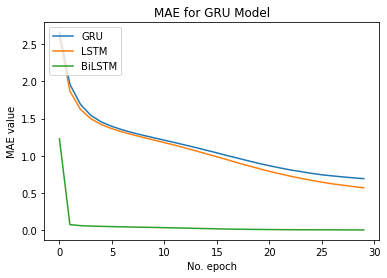

In [ ]:
# Plot history: MAE
plt.plot(history_1.history['loss'], label='GRU')
plt.plot(history_2.history['loss'], label='LSTM')
plt.plot(history_3.history['loss'], label='BiLSTM')
plt.title('MAE for GRU Model')
plt.ylabel('MAE value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

##  TF Serving

#### Create a temporary directory for Text Generation model

In [ ]:
import tempfile
import os

MODEL_DIR = tempfile.gettempdir()
version = 1
export_path = os.path.join(MODEL_DIR, str(version))
print('export_path = {}\n'.format(export_path))

tf.keras.models.save_model(
    model_gru,
    export_path,
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None
)

print('\nSaved model:')
!ls -l {export_path}

export_path = /tmp/1



INFO:tensorflow:Assets written to: /tmp/1/assets


INFO:tensorflow:Assets written to: /tmp/1/assets



Saved model:
total 716
drwxr-xr-x 2 root root   4096 Sep 28 15:02 assets
-rw-r--r-- 1 root root   9710 Sep 28 15:02 keras_metadata.pb
-rw-r--r-- 1 root root 712306 Sep 28 15:02 saved_model.pb
drwxr-xr-x 2 root root   4096 Sep 28 15:02 variables


#### Check if the saved model is properly formatted

In [ ]:
!saved_model_cli show --dir {MODEL_DIR}/1 --tag_set serve --signature_def serving_default

The given SavedModel SignatureDef contains the following input(s):
  inputs['embedding_input'] tensor_info:
      dtype: DT_FLOAT
      shape: (64, -1)
      name: serving_default_embedding_input:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['dense'] tensor_info:
      dtype: DT_FLOAT
      shape: (64, -1, 95)
      name: StatefulPartitionedCall:0
Method name is: tensorflow/serving/predict


#### Install the APT package for TF Serving

In [ ]:
!echo "deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | tee /etc/apt/sources.list.d/tensorflow-serving.list && \
curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | apt-key add -
!apt update

deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2943  100  2943    0     0   136k      0 --:--:-- --:--:-- --:--:--  136k
OK
Hit:1 http://storage.googleapis.com/tensorflow-serving-apt stable InRelease
Get:2 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:3 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:6 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  

In [ ]:
!apt-get install tensorflow-model-server

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  tensorflow-model-server
0 upgraded, 1 newly installed, 0 to remove and 79 not upgraded.
Need to get 347 MB of archives.
After this operation, 0 B of additional disk space will be used.
Get:1 http://storage.googleapis.com/tensorflow-serving-apt stable/tensorflow-model-server amd64 tensorflow-model-server all 2.6.0 [347 MB]
Fetched 347 MB in 5s (69.1 MB/s)
Selecting previously unselected package tensorflow-model-server.
(Reading database ... 155013 files and directories currently installed.)
Preparing to unpack .../tensorflow-model-server_2.6.0_all.deb ...
Unpacking tensorflow-model-server (2.6.0) ...
Setting up tensorflow-model-server (2.6.0) ...


In [ ]:
import requests

In [ ]:
import os
os.environ["MODEL_DIR"] = MODEL_DIR

#### Run a TF Serving server

In [ ]:
%%bash --bg 
nohup tensorflow_model_server \
  --rest_api_port=8510 \
  --model_name=gru_model_ \
  --model_base_path="${MODEL_DIR}" >server.log 2>&1

Starting job # 3 in a separate thread.


#### Check if the server runs properly

In [ ]:
!tail server.log

2021-09-28 15:19:24.571388: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:283] SavedModel load for tags { serve }; Status: success: OK. Took 215261 microseconds.
2021-09-28 15:19:24.576707: I tensorflow_serving/servables/tensorflow/saved_model_warmup_util.cc:59] No warmup data file found at /tmp/1/assets.extra/tf_serving_warmup_requests
2021-09-28 15:19:24.576873: I tensorflow_serving/core/loader_harness.cc:87] Successfully loaded servable version {name: gru_model_ version: 1}
2021-09-28 15:19:24.578258: I tensorflow_serving/model_servers/server_core.cc:486] Finished adding/updating models
2021-09-28 15:19:24.578325: I tensorflow_serving/model_servers/server.cc:133] Using InsecureServerCredentials
2021-09-28 15:19:24.578339: I tensorflow_serving/model_servers/server.cc:383] Profiler service is enabled
2021-09-28 15:19:24.578768: I tensorflow_serving/model_servers/server.cc:409] Running gRPC ModelServer at 0.0.0.0:8500 ...
[warn] getaddrinfo: address family for nodename 

## Making a request to the model in TensorFlow Serving

In [ ]:
import re
def process_inp(sentence):
  sentence = re.sub(r'[^\x00-\x7f]',r'', sentence)
  sentence = sentence.replace('\r', '')
  sentence = sentence.replace('\t', '')

  input_chars=tf.strings.unicode_split(sentence,'UTF-8')
  input_ids=ids_from_chars(input_chars)
  return input_ids

In [ ]:
from tensorflow.keras.layers.experimental import preprocessing
ids_from_chars = preprocessing.StringLookup(vocabulary=list(vocab),
                                            mask_token=None)

In [ ]:
sentence = "I hate this movie"


In [ ]:
batch=process_inp(sentence)
batch=batch.numpy()
batch=[batch]

In [ ]:
class NpEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        if isinstance(obj, np.floating):
            return float(obj)
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return super(NpEncoder, self).default(obj)

#### Making REST requests

In [ ]:
import pandas as pd
import json
data ={"instances":batch}
headers = {'content-type':'application/json'}
json_response = requests.post('http://localhost:8510/v1/models/gru_model_/:predict', data=json.dumps(data,cls=NpEncoder) 


predicted_logits = json.loads(json_response.text)["predictions"][0]

#predicted_logits=predicted_logits + prediction_mask
predicted_ids=tf.random.categorical(predicted_logits,num_samples=1)
predicted_ids=tf.squeeze(predicted_ids,axis=-1)
result_text = text_from_ids(predicted_ids).numpy()
print(result_text)

## Conclusions


* **GRU** :
   
  * Takes 12min 1s to train 30 EPOCHS
   
  

* **LSTM** :
  
  * Takes 15min 8s to train 30 EPOCHS
    
* **BiLSTM** :
  
  * Takes 28min 15s to train 30 EPOCHS

###  Readability: Transformers > GRU > LSTM > BiLSTM
    